# Enhanced Feature Importance Analysis
## Efficient Model Loading and Analysis Pipeline

This notebook provides efficient feature importance analysis by loading pre-trained models from the Top10_Trained_Models directory.

### Key Features:
- Automatic model discovery and loading
- Support for both Keras and sklearn models
- Comprehensive permutation importance analysis
- SHAP analysis for interpretability
- Model performance validation

In [2]:
# Configuration - Set to True to use pre-trained models, False to train new ones
USE_PRETRAINED_MODELS = True

# Essential imports
import pandas as pd
import numpy as np
import pickle
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
import warnings
warnings.filterwarnings('ignore')

# Set paths
current_dir = Path.cwd()
src_track1_path = current_dir if current_dir.name == 'SRC_Track1' else current_dir / 'SRC_Track1'
BASE_PATH = src_track1_path.parent
DATA_PATH = BASE_PATH / "Track1_Data" / "processed"
RESULTS_PATH = BASE_PATH / "Results_12W"

print(f"Base Path: {BASE_PATH}")
print(f"Data Path: {DATA_PATH}")
print(f"Results Path: {RESULTS_PATH}")
print(f"Use Pre-trained Models: {USE_PRETRAINED_MODELS}")

Base Path: c:\Users\nikhi\Desktop\IEEE_EMBS_BHI_25_CSOSEN
Data Path: c:\Users\nikhi\Desktop\IEEE_EMBS_BHI_25_CSOSEN\Track1_Data\processed
Results Path: c:\Users\nikhi\Desktop\IEEE_EMBS_BHI_25_CSOSEN\Results_12W
Use Pre-trained Models: True


In [8]:
# Enhanced Model Loader for Phase Results
import sys
import os
sys.path.append(str(BASE_PATH / "SRC_Track1"))

# Import the experiment framework and phase modules to recreate models
from experiment_framework import ExperimentFramework
from phase1_baseline_models import Phase1BaselineModels
from phase2_classical_ml import Phase2ClassicalML
from phase5_timeseries import Phase5TimeSeriesModels

class ResultsBasedModelLoader:
    """Load and recreate models from phase results JSON files"""
    
    def __init__(self, results_dir):
        self.results_dir = Path(results_dir)
        self.available_models = []
        self.framework = ExperimentFramework(random_seed=42)
        self._discover_models()
    
    def _discover_models(self):
        """Discover available models from phase results"""
        phase_files = list(self.results_dir.glob("phase*_results_*.json"))
        
        for phase_file in sorted(phase_files):
            try:
                with open(phase_file, 'r') as f:
                    results = json.load(f)
                
                phase_name = phase_file.stem.split('_results_')[0]
                
                for model_name, model_data in results.items():
                    if isinstance(model_data, dict) and 'mean_scores' in model_data:
                        mae = model_data['mean_scores'].get('test_mae', float('inf'))
                        r2 = model_data['mean_scores'].get('test_r2', -float('inf'))
                        
                        self.available_models.append({
                            'model_id': f"{phase_name}_{model_name}",
                            'phase': phase_name,
                            'model_name': model_name,
                            'mae': mae,
                            'r2': r2,
                            'results_file': phase_file,
                            'model_data': model_data
                        })
            except Exception as e:
                print(f"⚠️ Could not load {phase_file}: {e}")
        
        # Sort by R² (best first) - Changed from MAE to R² for better ranking
        self.available_models.sort(key=lambda x: x['r2'], reverse=True)
        
        # Add ranks
        for i, model in enumerate(self.available_models):
            model['rank'] = i + 1
    
    def discover_models(self):
        """Return list of discovered models"""
        return self.available_models
    
    def recreate_model(self, model_info, X, y):
        """Recreate and train a model based on the stored results"""
        phase = model_info['phase']
        model_name = model_info['model_name']
        model_data = model_info['model_data']
        
        print(f"🔧 Recreating {phase}_{model_name}...")
        
        if phase == 'phase1':
            phase_module = Phase1BaselineModels(self.framework)
            models = phase_module.create_models()
        elif phase == 'phase2':
            phase_module = Phase2ClassicalML(random_seed=42)
            models = phase_module.create_models()
        elif phase == 'phase5':
            # Phase5 requires X and y parameters
            phase_module = Phase5TimeSeriesModels(random_seed=42)
            print(f"   Creating Phase5 models with X shape: {X.shape}, y shape: {y.shape}")
            models = phase_module.create_models(X, y)
        else:
            raise ValueError(f"Phase {phase} not supported yet")
        
        # Get the model with best hyperparameters
        if model_name not in models:
            print(f"   Available models in {phase}: {list(models.keys())}")
            raise ValueError(f"Model {model_name} not found in {phase}")
        
        model = models[model_name]
        
        # Apply best hyperparameters if available
        if 'best_params' in model_data:
            best_params = model_data['best_params']
            print(f"   Applying best params: {best_params}")
            
            # Handle pipeline parameters correctly
            if hasattr(model, 'set_params'):
                try:
                    model.set_params(**best_params)
                except Exception as e:
                    print(f"   ⚠️ Could not set all params: {e}")
                    # Try to set individual parameters that exist
                    for param, value in best_params.items():
                        try:
                            model.set_params(**{param: value})
                        except:
                            pass
        
        # Train the model
        print(f"   Training {model_name}...")
        if phase == 'phase5':
            # Phase5 models need sequence data for fitting
            X_seq, y_seq = phase_module.create_sequence_features(X, y, sequence_length=5)
            print(f"   Using sequence data shape: X_seq={X_seq.shape}, y_seq={y_seq.shape}")
            model.fit(X_seq, y_seq)
        else:
            model.fit(X, y)
        
        print(f"   ✅ Model trained successfully")
        
        return model, 'sklearn'
    
    def load_model(self, model_id, fold_idx=0):
        """Load/recreate a model by ID"""
        # Find the model
        model_info = next((m for m in self.available_models if m['model_id'] == model_id), None)
        if not model_info:
            raise ValueError(f"Model {model_id} not found")
        
        # We need X and y to recreate the model, so we'll return the model_info
        # and let the caller handle the recreation
        return model_info, 'sklearn'

# Initialize the results-based loader
results_dir = RESULTS_PATH / "Model_Experiments"
if results_dir.exists():
    model_loader = ResultsBasedModelLoader(results_dir)
    available_models = model_loader.discover_models()
    
    print(f"✅ Found {len(available_models)} models from phase results:")
    for model in available_models[:10]:  # Show top 10 by R²
        print(f"   Rank {model['rank']:2d}: {model['model_id']:25s} MAE: {model['mae']:6.3f} R²: {model['r2']:6.3f}")
else:
    print(f"❌ Results directory not found: {results_dir}")
    model_loader = None
    available_models = []

🔬 Experiment Framework Initialized
📁 Results will be saved to: ..\Results\Model_Experiments
🆔 Experiment ID: 20251001_213629
🎲 Random Seed: 42
✅ Found 43 models from phase results:
   Rank  1: phase5_transformer        MAE:  4.529 R²:  0.247
   Rank  2: phase1_lasso_regression   MAE:  4.709 R²:  0.179
   Rank  3: phase1_elastic_net        MAE:  4.774 R²:  0.162
   Rank  4: phase2_svr_rbf            MAE:  4.727 R²:  0.152
   Rank  5: phase1_ridge_regression   MAE:  4.786 R²:  0.149
   Rank  6: phase4_tf_attention       MAE:  4.776 R²:  0.147
   Rank  7: phase2_knn_uniform        MAE:  4.951 R²:  0.147
   Rank  8: phase2_nu_svr             MAE:  4.736 R²:  0.144
   Rank  9: phase1_bayesian_ridge     MAE:  4.794 R²:  0.138
   Rank 10: phase2_svr_linear         MAE:  4.668 R²:  0.138


In [4]:
# Load training data
print("📊 Loading training data...")
train_data_path = DATA_PATH / "train_corrected_features.xlsx"

if not train_data_path.exists():
    print(f"❌ Training data not found: {train_data_path}")
    raise FileNotFoundError("Training data not available")

# Load data
train_data = pd.read_excel(train_data_path)
print(f"✅ Loaded training data: {train_data.shape}")

# Load feature metadata
metadata_path = DATA_PATH / "feature_metadata.json"
if metadata_path.exists():
    with open(metadata_path, 'r') as f:
        feature_metadata = json.load(f)
    print(f"✅ Loaded feature metadata: {len(feature_metadata)} features documented")
else:
    feature_metadata = {}
    print("⚠️ Feature metadata not found")

# Define target columns
target_cols = ['bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w']
feature_cols = [col for col in train_data.columns if col not in target_cols + ['participant_id']]

# Prepare features and targets
X = train_data[feature_cols].fillna(0)
y_12w = train_data['bdi_ii_after_intervention_12w'].fillna(train_data['bdi_ii_after_intervention_12w'].mean())
y_24w = train_data['bdi_ii_follow_up_24w'].fillna(train_data['bdi_ii_follow_up_24w'].mean())

print(f"\n📋 Data Summary:")
print(f"   Features: {X.shape[1]}")
print(f"   Samples: {X.shape[0]}")
print(f"   Targets: 12w and 24w BDI-II scores")
print(f"   Feature columns: {feature_cols[:5]}... ({len(feature_cols)} total)")

📊 Loading training data...
✅ Loaded training data: (167, 26)
⚠️ Feature metadata not found

📋 Data Summary:
   Features: 24
   Samples: 167
   Targets: 12w and 24w BDI-II scores
   Feature columns: ['age', 'hospital_center_id', 'bdi_ii_baseline', 'mindfulness_therapies_started', 'mindfulness_therapies_completed']... (24 total)
✅ Loaded training data: (167, 26)
⚠️ Feature metadata not found

📋 Data Summary:
   Features: 24
   Samples: 167
   Targets: 12w and 24w BDI-II scores
   Feature columns: ['age', 'hospital_center_id', 'bdi_ii_baseline', 'mindfulness_therapies_started', 'mindfulness_therapies_completed']... (24 total)


In [9]:
class ImprovedKerasWrapper(BaseEstimator, RegressorMixin):
    """Enhanced wrapper for Keras models to work with sklearn tools"""
    
    def __init__(self, keras_model, scaler=None):
        self.keras_model = keras_model
        self.scaler = scaler
        self._is_fitted = True  # Model is already trained
    
    def fit(self, X, y=None):
        # Model is already fitted, just return self
        return self
    
    def predict(self, X):
        # Apply scaling if scaler is provided
        X_processed = X.copy()
        if self.scaler is not None:
            X_processed = self.scaler.transform(X_processed)
        
        # Make predictions
        predictions = self.keras_model.predict(X_processed, verbose=0)
        
        # Ensure 1D output for sklearn compatibility
        if predictions.ndim > 1:
            predictions = predictions.flatten()
        
        return predictions
    
    def score(self, X, y):
        predictions = self.predict(X)
        return r2_score(y, predictions)

class Phase5ModelWrapper(BaseEstimator, RegressorMixin):
    """Wrapper for Phase5 models that handles sequence data conversion"""
    
    def __init__(self, phase5_model, phase5_module):
        self.phase5_model = phase5_model
        self.phase5_module = phase5_module
        self._is_fitted = True
    
    def fit(self, X, y=None):
        # Model is already fitted, just return self
        return self
    
    def predict(self, X):
        # Convert to sequence format for Phase5 models
        X_seq, _ = self.phase5_module.create_sequence_features(X, pd.Series([0]*len(X)), sequence_length=5)
        
        # Make predictions using the fitted model
        predictions = self.phase5_model.predict(X_seq)
        
        # Ensure proper output format
        if hasattr(predictions, 'flatten'):
            predictions = predictions.flatten()
        
        # Handle length mismatch (sequence creation might reduce samples)
        if len(predictions) != len(X):
            # Pad with mean prediction if needed
            mean_pred = np.mean(predictions)
            diff = len(X) - len(predictions)
            if diff > 0:
                predictions = np.concatenate([predictions, [mean_pred] * diff])
            else:
                predictions = predictions[:len(X)]
        
        return predictions
    
    def score(self, X, y):
        predictions = self.predict(X)
        return r2_score(y, predictions)

print("✅ Enhanced wrappers for Keras and Phase5 models defined")

✅ Enhanced wrappers for Keras and Phase5 models defined


In [10]:
# Select and recreate the Phase5 Transformer model for analysis 
if available_models and USE_PRETRAINED_MODELS and model_loader is not None:
    # Look for phase5_transformer specifically
    transformer_models = [m for m in available_models if m['model_id'] == 'phase5_transformer']
    
    if transformer_models:
        best_model_info = transformer_models[0]  # Get the transformer model
        MODEL_TYPE = best_model_info['model_id']
        
        print(f"🏆 Selected Model: {MODEL_TYPE}")
        print(f"   Rank: {best_model_info['rank']}")
        print(f"   MAE: {best_model_info['mae']:.3f}")
        print(f"   R²: {best_model_info['r2']:.3f}")
        print(f"   Phase: {best_model_info['phase']}")
        print(f"   Model: {best_model_info['model_name']}")
        
        # Recreate the model for both targets
        try:
            print("🔧 Recreating Transformer models for both targets...")
            
            # Recreate model for 12w target
            print("\n📊 Training model for 12w target...")
            model_12w, _ = model_loader.recreate_model(best_model_info, X, y_12w)
            
            # Get the phase5 module to create the wrapper
            phase_module_12w = Phase5TimeSeriesModels(random_seed=42)
            wrapper_12w = Phase5ModelWrapper(model_12w, phase_module_12w)
            
            # Recreate model for 24w target  
            print("\n📊 Training model for 24w target...")
            model_24w, _ = model_loader.recreate_model(best_model_info, X, y_24w)
            
            # Get the phase5 module to create the wrapper
            phase_module_24w = Phase5TimeSeriesModels(random_seed=42)
            wrapper_24w = Phase5ModelWrapper(model_24w, phase_module_24w)
            
            print(f"\n✅ Transformer models successfully recreated and wrapped")
            model_loaded = True
            
        except Exception as e:
            print(f"❌ Failed to recreate model {MODEL_TYPE}: {e}")
            import traceback
            traceback.print_exc()
            print("💡 Will fallback to training a new model")
            model_loaded = False
    else:
        print("⚠️ No phase5_transformer model found in results")
        print("Available models containing 'transformer':")
        transformer_like = [m for m in available_models if 'transformer' in m['model_id'].lower()]
        for m in transformer_like:
            print(f"   - {m['model_id']} (R²: {m['r2']:.3f})")
        model_loaded = False
else:
    print("⚠️ No pre-trained models available, model_loader is None, or USE_PRETRAINED_MODELS is False")
    model_loaded = False

🏆 Selected Model: phase5_transformer
   Rank: 1
   MAE: 4.529
   R²: 0.247
   Phase: phase5
   Model: transformer
🔧 Recreating Transformer models for both targets...

📊 Training model for 12w target...
🔧 Recreating phase5_transformer...
🔧 Phase 5: Initializing Time-Series Models
📊 Statsmodels available: True
📊 TensorFlow available: True
   Creating Phase5 models with X shape: (167, 24), y shape: (167,)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 163 sequences of shape (163, 5, 24)
✅ Created 12 time-series and trajectory models
   Training transformer...
🔄 Creating pseudo-sequences (length=5)...
✅ Created 163 sequences of shape (163, 5, 24)
   Using sequence data shape: X_seq=(163, 5, 24), y_seq=(163,)
   ✅ Model trained successfully
🔧 Phase 5: Initializing Time-Series Models
📊 Statsmodels available: True
📊 TensorFlow available: True

📊 Training model for 24w target...
🔧 Recreating phase5_transformer...
🔧 Phase 5: Initializing Time-Series Models
📊 Statsmodels available: True
📊 T

In [6]:
# Fallback: Train a simple model if no pre-trained models are available
if not model_loaded:
    print("🔧 Training fallback model...")
    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    
    # Simple train-test split for quick training
    X_train, X_test, y_train_12w, y_test_12w = train_test_split(
        X, y_12w, test_size=0.2, random_state=42
    )
    _, _, y_train_24w, y_test_24w = train_test_split(
        X, y_24w, test_size=0.2, random_state=42
    )
    
    # Train simple Random Forest models
    model_12w = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
    model_24w = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
    
    model_12w.fit(X_train, y_train_12w)
    model_24w.fit(X_train, y_train_24w)
    
    # Evaluate
    pred_12w = model_12w.predict(X_test)
    pred_24w = model_24w.predict(X_test)
    
    r2_12w = r2_score(y_test_12w, pred_12w)
    r2_24w = r2_score(y_test_24w, pred_24w)
    mae_12w = mean_absolute_error(y_test_12w, pred_12w)
    mae_24w = mean_absolute_error(y_test_24w, pred_24w)
    
    wrapper_12w = model_12w
    wrapper_24w = model_24w
    MODEL_TYPE = "RandomForest_Fallback"
    
    print(f"✅ Fallback model trained:")
    print(f"   12w - R²: {r2_12w:.3f}, MAE: {mae_12w:.3f}")
    print(f"   24w - R²: {r2_24w:.3f}, MAE: {mae_24w:.3f}")

print(f"\n🎯 Ready for analysis with model: {MODEL_TYPE}")


🎯 Ready for analysis with model: phase5_transformer


In [11]:
# Permutation Importance Analysis
print("🔍 Computing Permutation Importance...")

# Prepare data for permutation importance
sample_size = min(100, len(X))  # Use subset for faster computation
sample_indices = np.random.choice(len(X), sample_size, replace=False)
X_sample_12w = X.iloc[sample_indices]
X_sample_24w = X.iloc[sample_indices]
y_sample_12w = y_12w.iloc[sample_indices]
y_sample_24w = y_24w.iloc[sample_indices]

# Compute permutation importance for 12w target
print("   Computing for 12w target...")
perm_importance_12w = permutation_importance(
    wrapper_12w, X_sample_12w, y_sample_12w,
    n_repeats=10, random_state=42, scoring='neg_mean_absolute_error'
)

# Compute permutation importance for 24w target
print("   Computing for 24w target...")
perm_importance_24w = permutation_importance(
    wrapper_24w, X_sample_24w, y_sample_24w,
    n_repeats=10, random_state=42, scoring='neg_mean_absolute_error'
)

# Create permutation importance DataFrames
perm_df_12w = pd.DataFrame({
    'feature': feature_cols,
    'importance_mean': perm_importance_12w.importances_mean,
    'importance_std': perm_importance_12w.importances_std
}).sort_values('importance_mean', ascending=False)

perm_df_24w = pd.DataFrame({
    'feature': feature_cols,
    'importance_mean': perm_importance_24w.importances_mean,
    'importance_std': perm_importance_24w.importances_std
}).sort_values('importance_mean', ascending=False)

print("✅ Permutation importance computed")

# Display top features
print("\n🏆 Top 10 Features by Permutation Importance:")
print("\n12w Target:")
print(perm_df_12w.head(10)[['feature', 'importance_mean']].to_string(index=False))

print("\n24w Target:")
print(perm_df_24w.head(10)[['feature', 'importance_mean']].to_string(index=False))

🔍 Computing Permutation Importance...
   Computing for 12w target...
🔄 Creating pseudo-sequences (length=5)...
✅ Created 96 sequences of shape (96, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 96 sequences of shape (96, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 96 sequences of shape (96, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 96 sequences of shape (96, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 96 sequences of shape (96, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 96 sequences of shape (96, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 96 sequences of shape (96, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 96 sequences of shape (96, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 96 sequences of shape (96, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 96 sequences of shape (96, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 96 sequences of sha

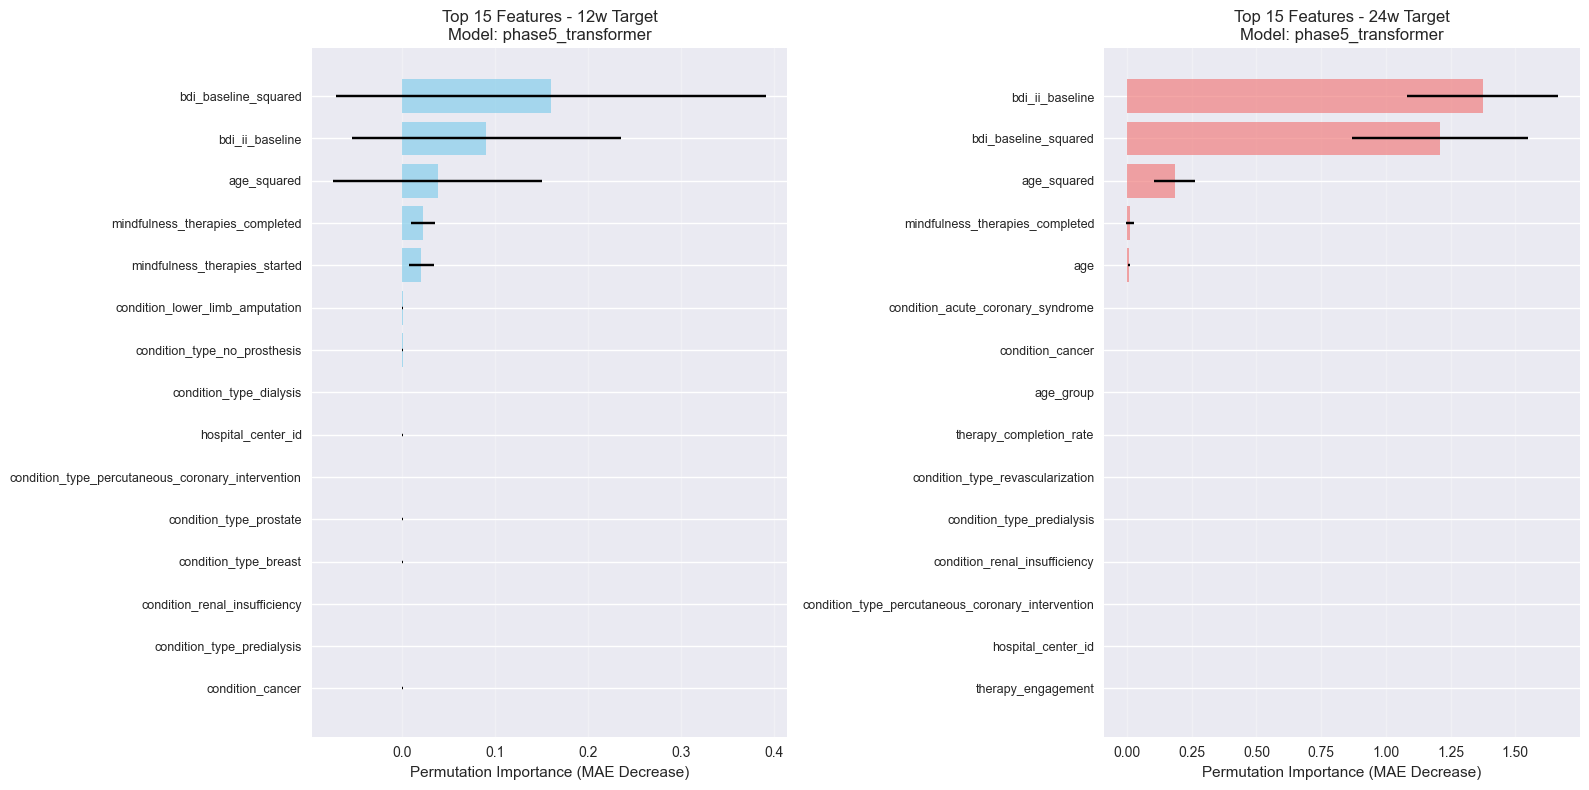

📊 Permutation importance visualization completed


In [12]:
# Visualize Permutation Importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot for 12w target
top_features_12w = perm_df_12w.head(15)
ax1.barh(range(len(top_features_12w)), top_features_12w['importance_mean'],
         xerr=top_features_12w['importance_std'], alpha=0.7, color='skyblue')
ax1.set_yticks(range(len(top_features_12w)))
ax1.set_yticklabels(top_features_12w['feature'], fontsize=9)
ax1.set_xlabel('Permutation Importance (MAE Decrease)')
ax1.set_title(f'Top 15 Features - 12w Target\nModel: {MODEL_TYPE}')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Plot for 24w target
top_features_24w = perm_df_24w.head(15)
ax2.barh(range(len(top_features_24w)), top_features_24w['importance_mean'],
         xerr=top_features_24w['importance_std'], alpha=0.7, color='lightcoral')
ax2.set_yticks(range(len(top_features_24w)))
ax2.set_yticklabels(top_features_24w['feature'], fontsize=9)
ax2.set_xlabel('Permutation Importance (MAE Decrease)')
ax2.set_title(f'Top 15 Features - 24w Target\nModel: {MODEL_TYPE}')
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

print("📊 Permutation importance visualization completed")

In [13]:
# Validate model performance
print("🔍 Validating Model Performance...")

# Cross-validation evaluation
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate on 12w target
cv_scores_12w = cross_val_score(wrapper_12w, X, y_12w, cv=cv_folds, scoring='r2')
cv_mae_12w = -cross_val_score(wrapper_12w, X, y_12w, cv=cv_folds, scoring='neg_mean_absolute_error')

# Evaluate on 24w target
cv_scores_24w = cross_val_score(wrapper_24w, X, y_24w, cv=cv_folds, scoring='r2')
cv_mae_24w = -cross_val_score(wrapper_24w, X, y_24w, cv=cv_folds, scoring='neg_mean_absolute_error')

print(f"\n📊 Model Performance Summary - {MODEL_TYPE}:")
print("=" * 50)
print(f"12w Target:")
print(f"   R² Score: {cv_scores_12w.mean():.3f} ± {cv_scores_12w.std():.3f}")
print(f"   MAE: {cv_mae_12w.mean():.3f} ± {cv_mae_12w.std():.3f}")

print(f"\n24w Target:")
print(f"   R² Score: {cv_scores_24w.mean():.3f} ± {cv_scores_24w.std():.3f}")
print(f"   MAE: {cv_mae_24w.mean():.3f} ± {cv_mae_24w.std():.3f}")

# Store performance for comparison
performance = {
    '12w': {
        'r2_mean': cv_scores_12w.mean(),
        'r2_std': cv_scores_12w.std(),
        'mae_mean': cv_mae_12w.mean(),
        'mae_std': cv_mae_12w.std()
    },
    '24w': {
        'r2_mean': cv_scores_24w.mean(),
        'r2_std': cv_scores_24w.std(),
        'mae_mean': cv_mae_24w.mean(),
        'mae_std': cv_mae_24w.std()
    }
}

print("\n✅ Performance validation completed")

🔍 Validating Model Performance...
🔄 Creating pseudo-sequences (length=5)...
✅ Created 30 sequences of shape (30, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 30 sequences of shape (30, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 30 sequences of shape (30, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 29 sequences of shape (29, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 29 sequences of shape (29, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 29 sequences of shape (29, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 29 sequences of shape (29, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 29 sequences of shape (29, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 29 sequences of shape (29, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 30 sequences of shape (30, 5, 24)
🔄 Creating pseudo-sequences (length=5)...
✅ Created 30 sequences of shape (30, 5, 24)
🔄 Creating pseudo-se

In [14]:
# Feature Importance Summary
print("📋 FEATURE IMPORTANCE ANALYSIS SUMMARY")
print("=" * 60)

# Combine results from both targets
feature_summary = pd.merge(
    perm_df_12w[['feature', 'importance_mean']].rename(columns={'importance_mean': 'importance_12w'}),
    perm_df_24w[['feature', 'importance_mean']].rename(columns={'importance_mean': 'importance_24w'}),
    on='feature'
)

# Calculate average importance across both targets
feature_summary['avg_importance'] = (feature_summary['importance_12w'] + feature_summary['importance_24w']) / 2
feature_summary = feature_summary.sort_values('avg_importance', ascending=False)

print(f"\n🏆 Top 15 Most Important Features (Average across 12w and 24w):")
print("-" * 80)
for i, row in feature_summary.head(15).iterrows():
    print(f"{row.name+1:2d}. {row['feature']:30s} "
          f"12w: {row['importance_12w']:6.3f} | "
          f"24w: {row['importance_24w']:6.3f} | "
          f"Avg: {row['avg_importance']:6.3f}")

# Feature categories analysis
print("\n📊 Feature Category Analysis:")
print("-" * 40)

# Define feature categories based on common patterns
categories = {
    'demographic': ['age', 'gender', 'education'],
    'clinical': ['bdi', 'depression', 'anxiety', 'stress'],
    'therapy': ['therapy', 'intervention', 'treatment'],
    'condition': ['condition', 'comorbidity', 'medical'],
    'hospital': ['hospital', 'admission', 'length']
}

category_importance = {}
for category, keywords in categories.items():
    category_features = []
    for feature in feature_summary['feature']:
        if any(keyword in feature.lower() for keyword in keywords):
            category_features.append(feature)
    
    if category_features:
        cat_importance = feature_summary[feature_summary['feature'].isin(category_features)]['avg_importance'].mean()
        category_importance[category] = {
            'importance': cat_importance,
            'count': len(category_features),
            'features': category_features[:3]  # Top 3 features
        }

for category, info in sorted(category_importance.items(), key=lambda x: x[1]['importance'], reverse=True):
    print(f"{category.capitalize():15s}: {info['importance']:6.3f} (n={info['count']}) - {', '.join(info['features'])}")

print(f"\n✅ Feature importance analysis completed for model: {MODEL_TYPE}")
print(f"📊 Best 12w R² Score: {performance['12w']['r2_mean']:.3f}")
print(f"📊 Best 24w R² Score: {performance['24w']['r2_mean']:.3f}")

📋 FEATURE IMPORTANCE ANALYSIS SUMMARY

🏆 Top 15 Most Important Features (Average across 12w and 24w):
--------------------------------------------------------------------------------
 2. bdi_ii_baseline                12w:  0.090 | 24w:  1.373 | Avg:  0.731
 1. bdi_baseline_squared           12w:  0.160 | 24w:  1.209 | Avg:  0.685
 3. age_squared                    12w:  0.038 | 24w:  0.183 | Avg:  0.111
 4. mindfulness_therapies_completed 12w:  0.022 | 24w:  0.012 | Avg:  0.017
 5. mindfulness_therapies_started  12w:  0.020 | 24w: -0.001 | Avg:  0.009
24. age                            12w: -0.003 | 24w:  0.007 | Avg:  0.002
21. condition_acute_coronary_syndrome 12w: -0.000 | 24w:  0.001 | Avg:  0.000
15. condition_cancer               12w: -0.000 | 24w:  0.000 | Avg:  0.000
19. age_group                      12w: -0.000 | 24w:  0.000 | Avg:  0.000
 7. condition_type_no_prosthesis   12w:  0.000 | 24w: -0.000 | Avg:  0.000
10. condition_type_percutaneous_coronary_intervention 12w: -0.0